In [1]:
#seaborn is required for the traceplots
import pysal as ps
import hlm
from hlm.verify import Delta_members
from hlm.plotting.traces import plot_trace
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df[df.STATE_NAME != 'District of Columbia']
X = df[['GI89', 'BLK90', 'HR90']].values
N = X.shape[0]
Z = df.groupby('STATE_NAME')['FH90'].mean()
Z = Z.values.reshape(-1,1)
J = Z.shape[0]

Y = df.DNL90.values.reshape(-1,1)
W2 = ps.queen_from_shapefile(ps.examples.get_path('us48.shp'), 
                             idVariable='STATE_NAME')
W2 = ps.w_subset(W2, ids=df.STATE_NAME.unique().tolist())
W1 = ps.queen_from_shapefile(ps.examples.get_path('south.shp'),
                             idVariable='FIPS')
W1 = ps.w_subset(W1, ids=df.FIPS.tolist())

W1.transform = 'r'
W2.transform = 'r'
membership = df.STATE_NAME.apply(lambda x: W2.id_order.index(x)).values
Delta, membership = Delta_members(None, membership, W1.n, W2.n)

In [2]:
WZ = ps.lag_spatial(W2, Z)
ZDurbin = np.hstack((Z, WZ))

In [3]:
m2 = hlm.upper.SMA(Y, X, M=W2, Z=ZDurbin, membership=membership,
                   n_samples=5000)

/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


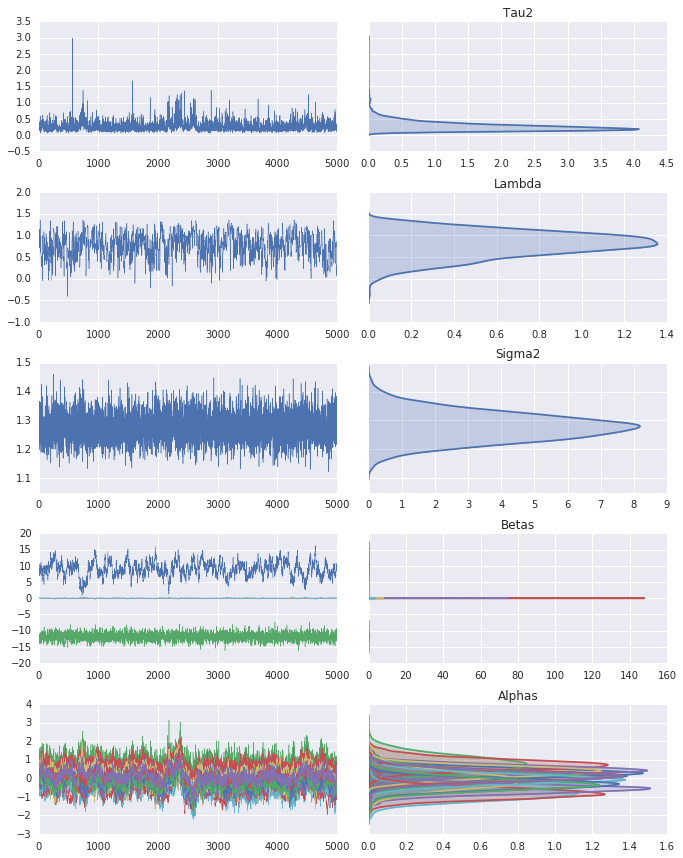

In [4]:
plot_trace(m2)
plt.tight_layout()
plt.show()

In [5]:
m3 = hlm.upper.SE(Y, X, M=W2, Z=ZDurbin, 
                  membership=membership, n_samples=5000)

/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


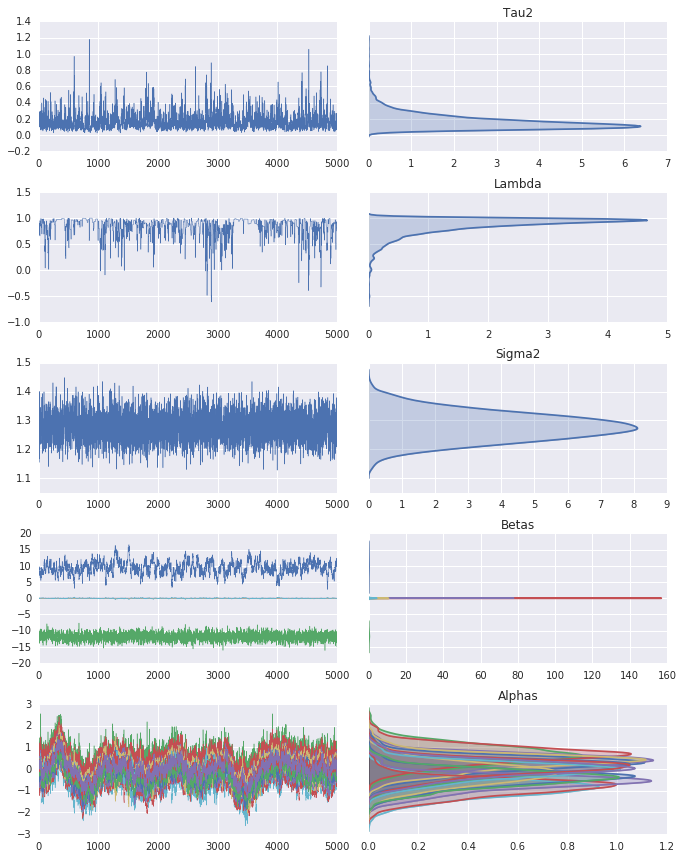

In [8]:
m3.trace.plot()
plt.tight_layout()

In [11]:
true_betas = np.array([[3,5,6]]).T
true_gamma = np.array([[-3, 10]]).T
true_lambda = .45

In [12]:
linpred = 1 + X.dot(true_betas) + Delta.dot(ZDurbin).dot(true_gamma)
B = (np.eye(W2.n) - true_lambda * W2.full()[0])
error = Delta.dot(np.linalg.inv(B)).dot(np.random.normal(0,1,size=Z.shape))
error += np.random.normal(0,.2, size=(X.shape[0], 1))
Y = linpred + error

In [13]:
m3 = hlm.upper.SE(Y, X, M=W2, Z=ZDurbin, 
                  membership=membership, n_samples=5000)

/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


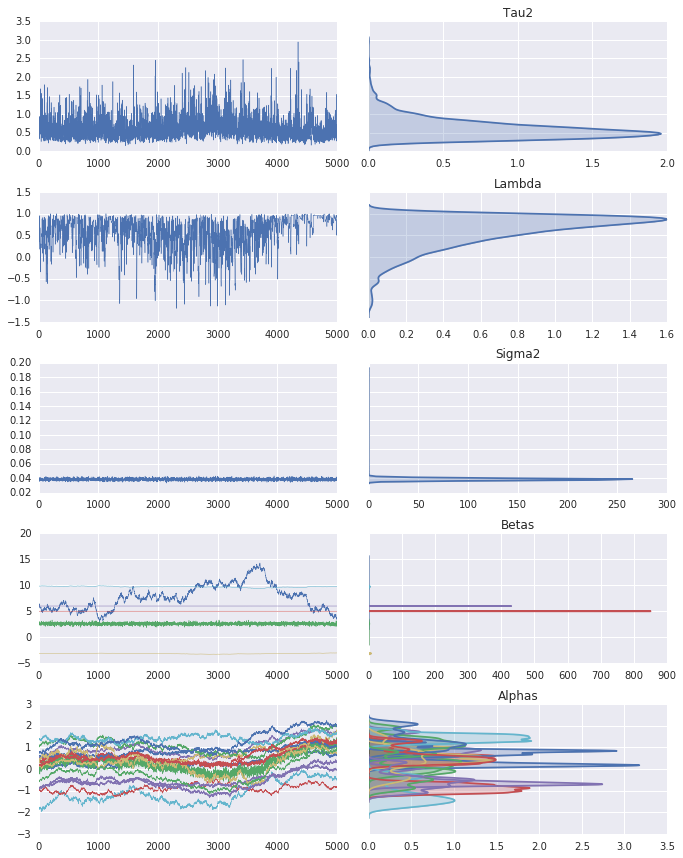

In [14]:
plot_trace(m3)
plt.tight_layout()

In [16]:
mvcm = hlm.both.MVCM(Y, X, Z=ZDurbin, 
                     membership=membership, n_samples=5000)

/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


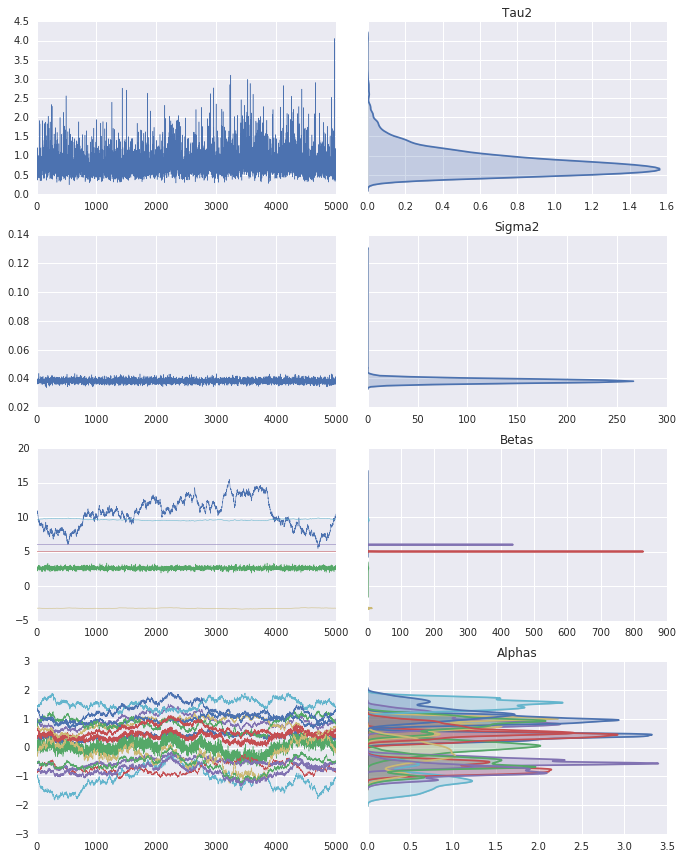

In [17]:
mvcm.trace.plot()
plt.tight_layout()

In [20]:
m4 = hlm.both.Generic(Y, X, Z=ZDurbin, W=W1, M=W2,
                      membership=membership, n_samples=5000)

/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/abstracts.py:38: UserWarning: Sampling interrupted, drew 1570 samples
  Warn('Sampling interrupted, drew {} samples'.format(self.cycles))


/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


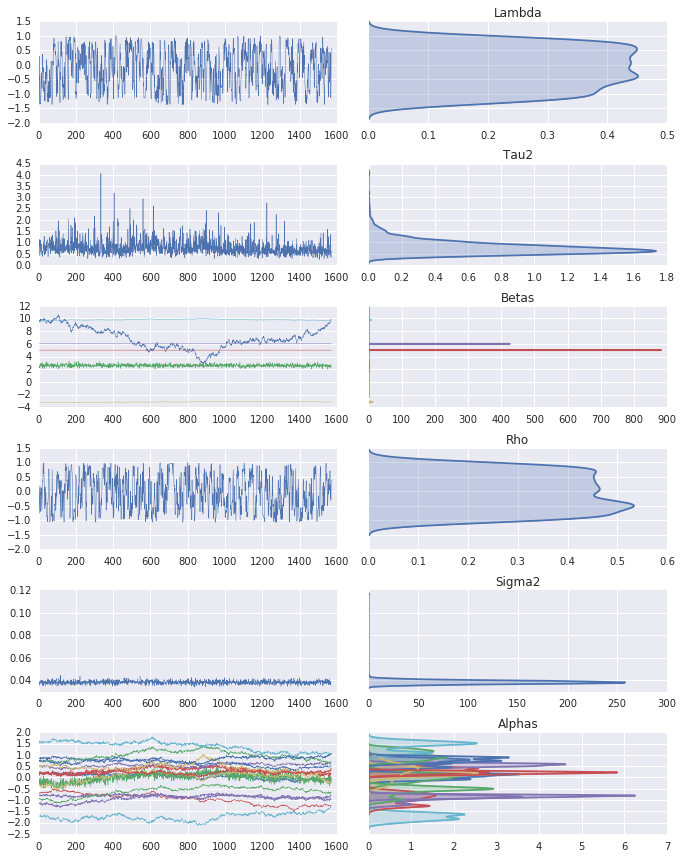

In [21]:
m4.trace.plot()
plt.tight_layout()

In [24]:
import pandas as pd

In [25]:
pd.DataFrame([m4.trace.to_df().mean(), mvcm.trace.to_df().mean()]).T

,0,1
Alphas_0,0.042976,0.370788
Alphas_1,0.001364,0.018086
Alphas_10,0.239981,-0.232404
Alphas_11,1.388786,1.518264
Alphas_12,0.788608,1.244799
Alphas_13,-0.609997,-0.589036
Alphas_14,0.202616,0.593573
Alphas_15,-0.931109,-0.819365
Alphas_2,0.311492,0.388391
Alphas_3,0.539329,0.922664
